In [2]:
!rm -rf /kaggle/working/looped_transformer/

In [3]:
!git clone https://github.com/DMurawiecki/looped_transformer.git
!ls

Cloning into 'looped_transformer'...
remote: Enumerating objects: 571, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 571 (delta 117), reused 104 (delta 104), pack-reused 442
Receiving objects: 100% (571/571), 67.83 MiB | 40.62 MiB/s, done.
Resolving deltas: 100% (364/364), done.
looped_transformer


In [4]:
!pip install funcy

In [5]:
!pip install wandb

In [6]:
!pip3 install -U zetascale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.4/872.4 kB 17.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 56.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: rich
    Found existing installation: rich 13.7.0
    Uninstalling rich-13.7.0:
      Successfully uninstalled rich-13.7.0
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
ERROR

In [7]:
import sys
import torch
import numpy
import yaml
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('/kaggle/working/looped_transformer/')
sys.path.append('/kaggle/working/looped_transformer/scripts/')
# from models import build_model
from tasks import get_task_sampler
from nano_gpt import GPT2Model, GPT2Config, LayerNorm
from main_utils import gen_dataloader
from models import TransformerModel, TransformerModelLooped
from curriculum import *
from train import calculate_gradient_norm
from train_implementation_wandb import train_step, train_model_wandb
from utilities import set_optim_scaler_curriculum_by_args
from eval_and_save import evaluate_model, save_model
import wandb

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
starting_step = 0
ending_step = 50
ctx = True

torch.set_float32_matmul_precision('highest')
torch.backends.cuda.matmul.allow_tf32 = True  # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True  # allow tf32 on cudnn
dtype = 'float16'  # 'bfloat16', 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

# Training Looped Model with logging to Weights&Biases

In [9]:
device

device(type='cuda')

#Models' Baseline Training


In [10]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

number of parameters: 9.48M


wandb: Currently logged in as: mdr333. Use `wandb login --relogin` to force relogin


  0%|          | 0/50 [00:00<?, ?it/s]

0


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


training loss,▄█▃▃▂▂▂▃▃▃▃▄▂▄▃▂▁▃▄▃▃▃▃▂▃▂▁▃▃▁▃▁▃▂▂▂▄▂▂▂
validation loss,█▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training loss,3.75635
validation loss,3.22221


your model was saved


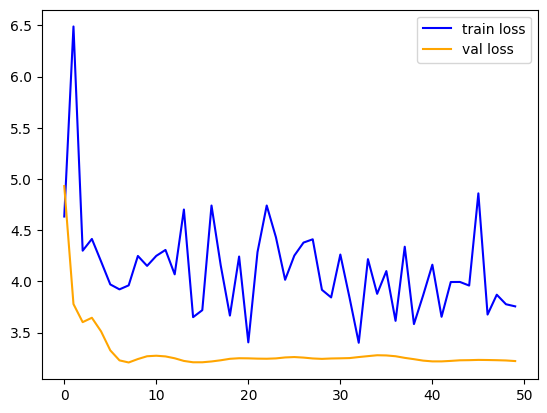

In [11]:
n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8
n_dims= 4
torch.manual_seed(42)
args_path='/kaggle/working/looped_transformer/configs/base_loop_4dim.yaml'

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head).to(device)
optimizer, scaler, curriculum, args = set_optim_scaler_curriculum_by_args(args_path=args_path, model= model)
losses_baseline, losses_val = train_model_wandb(starting_step=starting_step,
                     ending_step= ending_step,
                     args= args,
                     model= model,
                     ctx= ctx,
                     add_inputs_embeds= False,
                     optimizer=optimizer,
                     curriculum= curriculum,
                     scaler= scaler,
                     device = device,
                     run_name = 'Mean_window')
save_model(model, path= '/kaggle/working/state_150k.pt')
plt.plot(losses_baseline, label='train loss', color='blue')
plt.plot(losses_val, label='val loss', color='orange')
plt.legend()
plt.show()